# Propensity Score Stratification (PSS)
Propensity score stratification is simpler, preserves more data, and supports subgroup analysis better than matching—making it a strong choice for large observational studies with good treatment–control overlap.

**Propensity Score Matching (PSM) vs. Propensity Score Stratification (PSS)**

| Aspect                           | Propensity Score Matching (PSM)                     | Propensity Score Stratification (PSS)                       |
| -------------------------------- | --------------------------------------------------- | ----------------------------------------------------------- |
| Sample Use                   | Discards unmatched units → smaller sample           | Keeps all units → preserves sample size                     |
| Statistical Power            | Reduced due to data loss                            | Higher power with full data inclusion                       |
| Subgroup Insights | Harder to examine variation across groups           | Easily compare effects across strata/subgroups              |
| Interpretability             | Can be more complex to explain to non-experts       | Clearer explanation for stakeholders (e.g., administrators) |
| When Best Used               | When exact, tight matches are critical              | When representativeness and transparency matter             |

### Propensity Score Definition

The propensity score is the probability of receiving the treatment given covariates (X):

$$
p(X) = P(T = 1 \mid X)
$$

where:

* $ T = 1 $ if the unit receives treatment, (0) otherwise.
* $ X$  is the vector of observed covariates.


In propensity score stratification, the idea is to divide units into $K$  strata based on the estimated propensity score $ \hat{e}(X)$ , such that within each stratum, treated and control units have similar covariate distributions.

Let the strata be:

$$
S_1, S_2, \dots, S_K
$$

where

$$
S_k = { i : \hat{p}(X_i) \in [q_{k-1}, q_k) }
$$

with $q_k$ being the $k$-th quantile of $\hat{p}(X)$.

Within stratum $k$, the **stratum-specific treatment effect** is:

$$
\hat{\tau}_k = \frac{1}{n_{k1}} \sum_{i \in S_k, T_i = 1} Y_i - \frac{1}{n_{k0}} \sum_{i \in S_k, T_i = 0} Y_i
$$

where:

* $n_{k1}$ = number of treated units in stratum $k$
* $n_{k0}$ = number of control units in stratum $k$
* $Y_i$ = outcome for unit $i$

The overall treatment effect is obtained by **weighting the stratum-specific effects** by the proportion of units in each stratum:

$$
\hat{\tau}_{ATE} = \sum_{k=1}^{K} w_k  \hat{\tau}_k
$$

with

$$
w_k = \frac{n_k}{n}, \quad n_k = n_{k0} + n_{k1}, \quad n = \sum_{k=1}^{K} n_k
$$

So $w_k$ is the proportion of all units in stratum $k$.

### An example to explain how to get the overall ATE
Approach: The stratum-specific effects are calculated and then weighted to get the overall ATE.

1. Suppose we have 10 students with covariates \( X \) (e.g., prior score, SES, parent education), and we estimate their propensity scores $ \hat{p}(X) $:

| Student | Treated (T) | Outcome (Y) | Propensity Score $ \hat{p}(X) $ |
|---------|-------------|-------------|-----------------------------|
| 1       | 1           | 85          | 0.80                        |
| 2       | 0           | 78          | 0.75                        |
| 3       | 1           | 90          | 0.70                        |
| 4       | 0           | 82          | 0.65                        |
| 5       | 1           | 88          | 0.60                        |
| 6       | 0           | 75          | 0.55                        |
| 7       | 1           | 92          | 0.40                        |
| 8       | 0           | 70          | 0.35                        |
| 9       | 1           | 89          | 0.30                        |
| 10      | 0           | 74          | 0.25                        |

2. Let’s use 2 strata (i.e., $ K = 2 $) based on quantiles of $ \hat{p}(X) $:

- Stratum 1: Low propensity scores (0.25–0.55)
- Stratum 2: High propensity scores (0.60–0.80)

So:

- Stratum 1: Students 6, 7, 8, 9, 10
- Stratum 2: Students 1, 2, 3, 4, 5

3. We compute the treatment effect within each stratum

Stratum 1:

- Treated: Students 7, 9 → Outcomes: 92, 89 → Average = $ \frac{92 + 89}{2} = 90.5 $
- Control: Students 6, 8, 10 → Outcomes: 75, 70, 74 → Average = $ \frac{75 + 70 + 74}{3} = 73.0 $

Stratum Treatment Effect:

$$
\hat{\tau}_1 = 90.5 - 73.0 = 17.5
$$


Stratum 2:

- Treated: Students 1, 3, 5 → Outcomes: 85, 90, 88 → Average = $ \frac{85 + 90 + 88}{3} = 87.67 $
- Control: Students 2, 4 → Outcomes: 78, 82 → Average = $ \frac{78 + 82}{2} = 80.0 $

Stratum Treatment Effect:

$$
\hat{\tau}_2 = 87.67 - 80.0 = 7.67
$$

4. Let’s compute weights:

- $ n_1 = 5 $ (Stratum 1 has 5 students)
- $ n_2 = 5 $ (Stratum 2 has 5 students)
- Total $ n = 10 $

So:

- $ w_1 = \frac{5}{10} = 0.5 $
- $ w_2 = \frac{5}{10} = 0.5 $

5. Thus, the overall ATE:

$$
\hat{\tau}_{ATE} = 0.5 \cdot 17.5 + 0.5 \cdot 7.67 = 8.75 + 3.835 = 12.585
$$

## Case Study

An urban school district runs an **after-school tutoring program** aimed at improving students' **final exam scores**. The program particularly outreaches to students with lower prior achievement and from lower socioeconomic status (SES). Parents with higher education are somewhat less likely to enroll their children. You want to estimate the causal effect of the tutoring program on final exam performance while adjusting for confounding factors.

* Treatment: participation in the after-school tutoring program (`treatment`, 1 = participated).
* Outcome: final exam score (`final_score`, numeric).
* Observed confounders: prior academic score (`prior_score`), socioeconomic status (`ses` — low/medium/high), parental education (`parent_edu`), hours studied per week (`hours_studied`), and attendance rate (`attendance`).

True data-generating choices:

* The tutoring program has a true additive effect of **+3 points** on final exam score.
* Program participation is more likely for **lower prior_score** and **low SES** students (targeting), and less likely when `parent_edu` is high.
* Outcome depends on prior_score, hours studied, attendance, SES, parental education, and treatment.

In [102]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dowhy import CausalModel

np.random.seed(2025)

n = 1500  # large enough for stratification

# Confounders
ses = np.random.choice([0,1,2], size=n, p=[0.35, 0.45, 0.20])
parent_edu = np.random.choice([0,1,2], size=n, p=[0.4, 0.35, 0.25])

# Prior academic score
prior_score_raw = np.random.normal(70, 10, size=n)
prior_score = np.clip(prior_score_raw, 30, 100)

# Hours studied per week
hours_raw = np.random.normal(
    5 + 0.05*(prior_score-70) + 0.8*(parent_edu==2), 2, size=n
)
hours_studied = np.clip(hours_raw, 0, 30)

# Attendance
attendance_raw = np.random.normal(
    0.85 + 0.02*(prior_score-70) - 0.04*(ses==0), 0.07, size=n
)
attendance = np.clip(attendance_raw, 0.5, 1.0)

# Treatment assignment (logistic model)
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

logit = (
    -0.5
    - 0.05*(prior_score - 70)
    + 0.3*(ses == 0)
    - 0.2*(ses == 2)
    - 0.2*(parent_edu == 2)
)

treatment_prob = sigmoid(logit)
treatment = np.random.binomial(1, treatment_prob, size=n)

# Outcome
true_treatment_effect = 3.0
noise = np.random.normal(0, 4, size=n)
final_score = (
    30
    + 0.45 * prior_score
    + 1.8 * hours_studied
    + 8.0 * attendance
    + 1.5 * (parent_edu == 2)
    - 2.0 * (ses == 0)
    + true_treatment_effect * treatment
    + noise
)

# Dataframe
data = pd.DataFrame({
    "ses": ses,
    "parent_edu": parent_edu,
    "prior_score": np.round(prior_score, 2),
    "hours_studied": np.round(hours_studied, 2),
    "attendance": np.round(attendance, 3),
    "treatment": treatment,
    "treatment_prob": np.round(treatment_prob, 3),
    "final_score": np.round(final_score, 2)
})

# Add readable labels
data["ses_label"] = data["ses"].map({0: "low", 1: "medium", 2: "high"})
data["parent_edu_label"] = data["parent_edu"].map({0: "no_college", 1: "some_college", 2: "college_plus"})

## DAG

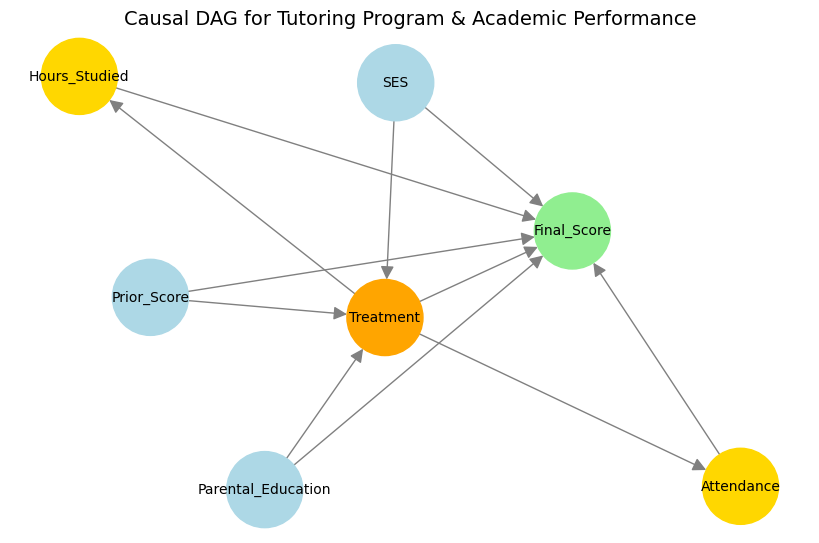

In [103]:
import matplotlib.pyplot as plt
import networkx as nx

# Create DAG
G = nx.DiGraph()

edges = [
    ("SES", "Treatment"),
    ("Parental_Education", "Treatment"),
    ("Prior_Score", "Treatment"),
    ("SES", "Final_Score"),
    ("Parental_Education", "Final_Score"),
    ("Prior_Score", "Final_Score"),
    ("Hours_Studied", "Final_Score"),
    ("Attendance", "Final_Score"),
    ("Treatment", "Final_Score"),
    # Post-treatment mediator edges
    ("Treatment", "Hours_Studied"),
    ("Treatment", "Attendance"),
]

G.add_edges_from(edges)

# Node colors: Confounders (blue), Treatment (orange), Mediators (yellow), Outcome (green)
node_colors = {
    "SES": "lightblue",
    "Parental_Education": "lightblue",
    "Prior_Score": "lightblue",
    "Hours_Studied": "gold",
    "Attendance": "gold",
    "Treatment": "orange",
    "Final_Score": "lightgreen"
}

pos = nx.spring_layout(G, seed=42)

# Plot
plt.figure(figsize=(8, 5))
nx.draw(
    G, pos, with_labels=True,
    node_color=[node_colors[node] for node in G.nodes()],
    node_size=3000, arrowsize=20, edge_color='gray',
    font_size=10,
)
plt.title("Causal DAG for Tutoring Program & Academic Performance", fontsize=14)
plt.show()


## EDA

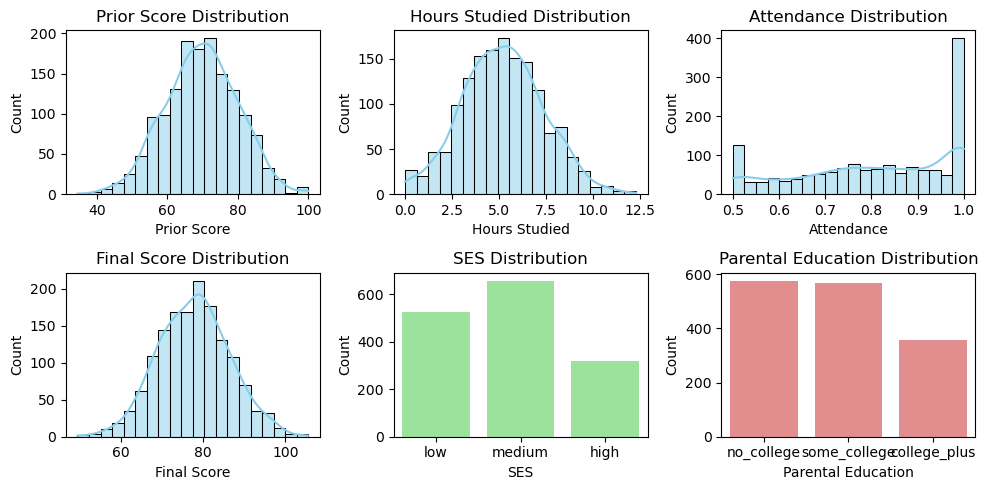

In [104]:
import matplotlib.pyplot as plt
import seaborn as sns

# Columns to plot
numeric_cols = ["prior_score", "hours_studied", "attendance", "final_score"]
categorical_cols = ["ses_label", "parent_edu_label"]

plt.figure(figsize=(10,5))
for i, col in enumerate(numeric_cols):
    plt.subplot(2, 3, i+1)
    sns.histplot(data[col], bins=20, kde=True, color="skyblue")
    plt.title(f"{col.replace('_',' ').title()} Distribution")
    plt.xlabel(col.replace('_',' ').title())
    plt.ylabel("Count")

plt.subplot(2, 3, 5)  
sns.countplot(
    data=data,
    x="ses_label",
    order=["low","medium","high"],
    color="lightgreen"
)
plt.title("SES Distribution")
plt.xlabel("SES")
plt.ylabel("Count")

plt.subplot(2, 3, 6)  
sns.countplot(
    data=data,
    x="parent_edu_label",
    order=["no_college","some_college","college_plus"],
    color="lightcoral"
)
plt.title("Parental Education Distribution")
plt.xlabel("Parental Education")
plt.ylabel("Count")

plt.tight_layout()
plt.show()

## DoWhy - Propensity Score Stratification

### Overall ATE

In [138]:
# Steps 1, 2
model = CausalModel(
    data=data,
    treatment="treatment",
    outcome="final_score",
    common_causes=confounders
)
# Step 3
identified_estimand = model.identify_effect()
# Step 4
ate_estimate = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.propensity_score_stratification",
    target_units="ate"
)
    
# Bootstrap confidence intervals
ci = ate_estimate.get_confidence_intervals(method="bootstrap", num_simulations=100)
# Print ATE and its 95% confidence interval
print("Estimated ATE:", ate_estimate.value)
print("95% Confidence Interval:", ate_estimate.get_confidence_intervals())

# Step 5
# Refutation tests for robustness
ref_placebo = model.refute_estimate(identified_estimand, ate_estimate, method_name="placebo_treatment_refuter")
print("\nPlacebo Test:", ref_placebo)

ref_subset = model.refute_estimate(identified_estimand, ate_estimate, method_name="data_subset_refuter")
print("\nSubset Test:", ref_subset)

ref_boot = model.refute_estimate(identified_estimand, ate_estimate, method_name="bootstrap_refuter")
print("\nBootstrap Test:", ref_boot)

Estimated ATE: 3.0486347066088073
95% Confidence Interval: (2.259058077962491, 3.81140648394196)

Placebo Test: Refute: Use a Placebo Treatment
Estimated effect:3.0486347066088073
New effect:-0.00339748081901099
p value:0.98


Subset Test: Refute: Use a subset of data
Estimated effect:3.0486347066088073
New effect:3.10672510588386
p value:0.72


Bootstrap Test: Refute: Bootstrap Sample Dataset
Estimated effect:3.0486347066088073
New effect:3.07546984189337
p value:0.96



### CATEs

In [105]:
confounders = ["prior_score", "ses", "parent_edu"]

def estimate_effect_subgroup(df, subgroup_condition, target_units="ate"):
    df_sub = df.loc[subgroup_condition].copy()
    
    # Skip very small subgroups
    treated_count = df_sub['treatment'].sum()
    untreated_count = len(df_sub) - treated_count
    min_per_group = 5
    if treated_count < min_per_group or untreated_count < min_per_group:
        return np.nan, (np.nan, np.nan)

    # Steps 1, 2
    model = CausalModel(
        data=df_sub,
        treatment="treatment",
        outcome="final_score",
        common_causes=confounders
    )
    # Step 3
    identified_estimand = model.identify_effect()
    # Step 4
    estimate = model.estimate_effect(
        identified_estimand,
        method_name="backdoor.propensity_score_stratification",
        method_params={"num_strata": 2, "clipping_threshold": min_per_group},
        target_units=target_units
    )
    
    # Bootstrap confidence intervals
    ci = estimate.get_confidence_intervals(method="bootstrap", num_simulations=100)
    return estimate.value, ci

ses_labels = ["low", "medium", "high"]
parent_labels = ["no_college", "some_college", "college_plus"]

results = []
for ses in ses_labels:
    for parent in parent_labels:
        cond = (data["ses_label"] == ses) & (data["parent_edu_label"] == parent)
        
        ate, ate_ci = estimate_effect_subgroup(data, cond, target_units="ate")
        att, att_ci = estimate_effect_subgroup(data, cond, target_units="att")
        
        results.append({
            "SES": ses,
            "Parental_Education": parent,
            "CATE_Group": f"{ses}-{parent}",  # Explicit CATE label
            "ATE": ate,
            "ATE_CI_Lower": ate_ci[0],
            "ATE_CI_Upper": ate_ci[1],
            "ATT": att,
            "ATT_CI_Lower": att_ci[0],
            "ATT_CI_Upper": att_ci[1]
        })

results_df = pd.DataFrame(results)
print(results_df)

      SES Parental_Education           CATE_Group       ATE  ATE_CI_Lower  \
0     low         no_college       low-no_college  1.834743     -0.135917   
1     low       some_college     low-some_college  1.462531     -1.082947   
2     low       college_plus     low-college_plus  4.069687      2.311357   
3  medium         no_college    medium-no_college  3.548794      1.727226   
4  medium       some_college  medium-some_college  1.606528     -0.214505   
5  medium       college_plus  medium-college_plus  3.000591      0.640063   
6    high         no_college      high-no_college  5.005112      1.326482   
7    high       some_college    high-some_college  0.473484     -1.753347   
8    high       college_plus    high-college_plus  3.734189     -0.169915   

   ATE_CI_Upper       ATT  ATT_CI_Lower  ATT_CI_Upper  
0      3.556645  1.787411     -0.074348      3.715950  
1      2.852889  1.580859     -0.457129      3.257858  
2      7.183271  3.902374      2.112906      7.214113  
3    

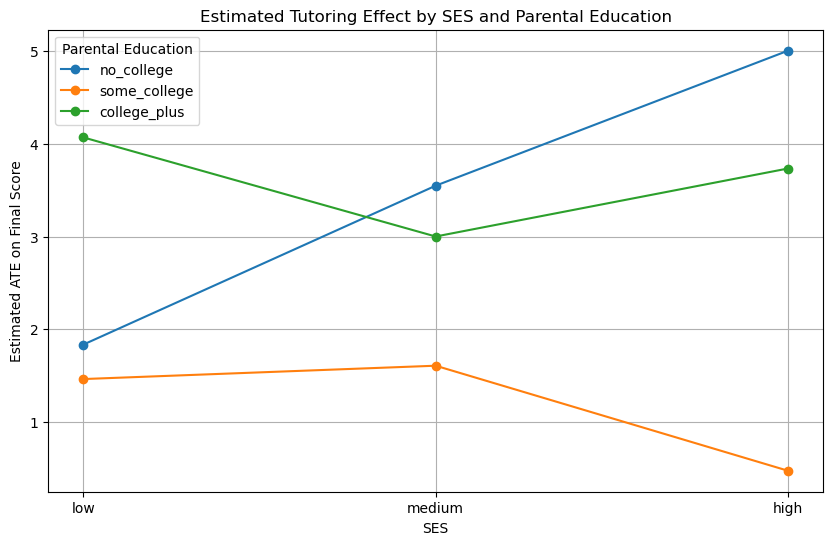

In [106]:
plt.figure(figsize=(10,6))

for parent in parent_labels:
    subset = results_df[results_df["Parental_Education"]==parent]
    plt.plot(subset["SES"], subset["ATE"], marker='o', label=parent)

plt.xlabel("SES")
plt.ylabel("Estimated ATE on Final Score")
plt.title("Estimated Tutoring Effect by SES and Parental Education")
plt.legend(title="Parental Education")
plt.grid(True)
plt.show()

### Manual PSS 

In [107]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression

# Select confounders
confounders = ["prior_score", "ses", "parent_edu"]

# One-hot encode ses and parent_edu
data_encoded = pd.get_dummies(data[confounders], columns=["ses", "parent_edu"], drop_first=True)

# Propensity score
ps_model = LogisticRegression()
ps_model.fit(data_encoded, data["treatment"])

# Add propensity scores to original dataframe
data["propensity_score"] = ps_model.predict_proba(data_encoded)[:,1]

# Into strata
data["ps_stratum"] = pd.qcut(data["propensity_score"], q=10, labels=False)

   prior_score  ses_1  ses_2  parent_edu_1  parent_edu_2
0        56.26  False  False          True         False
1        69.60  False   True         False         False
2        77.86  False   True          True         False
3        63.89   True  False         False         False
4        82.47   True  False          True         False


In [131]:
strata_results = []

for s in sorted(data["ps_stratum"].unique()):
    subset = data[data["ps_stratum"] == s]
    min_ps = subset['propensity_score'].min()
    max_ps = subset['propensity_score'].max()
    treated_count = subset[subset["treatment"]==1]["final_score"].count()
    control_count = subset[subset["treatment"]==0]["final_score"].count()
    treated_mean = subset[subset["treatment"]==1]["final_score"].mean()
    control_mean = subset[subset["treatment"]==0]["final_score"].mean()
    ate = treated_mean - control_mean
    strata_results.append({
        "Stratum": s,
        "Min_PS":min_ps,
        "Max_PS":max_ps,
        "Treated_Count": treated_count,
        "Control_Count": control_count,
        "Treated_Mean": treated_mean,
        "Control_Mean": control_mean,
        "ATE": ate
    })

strata_df = pd.DataFrame(strata_results).round(2)
strata_df

,Stratum,Min_PS,Max_PS,Treated_Count,Control_Count,Treated_Mean,Control_Mean,ATE
0,0,0.13,0.25,27,123,88.52,86.91,1.60
1,1,0.25,0.29,44,106,86.61,83.28,3.33
2,2,0.29,0.32,49,101,83.85,80.76,3.09
3,3,0.32,0.34,47,103,82.32,78.92,3.41
4,4,0.34,0.37,50,100,79.82,78.39,1.43
5,5,0.37,0.40,57,93,79.83,76.60,3.22
6,6,0.40,0.44,62,88,77.41,74.14,3.27
7,7,0.44,0.47,71,79,76.06,72.42,3.64
8,8,0.47,0.52,79,71,73.30,69.08,4.22
9,9,0.52,0.71,84,66,67.71,65.43,2.28


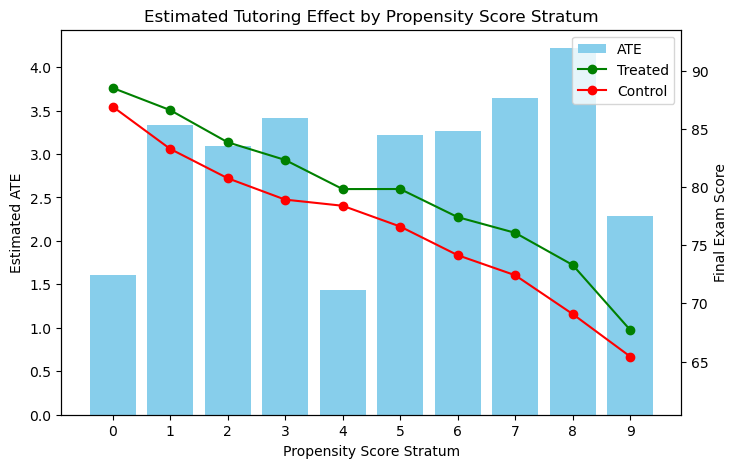

In [115]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(8,5))

# Plot ATE bars
ax1.bar(strata_df["Stratum"], strata_df["ATE"], color="skyblue", label="ATE")
ax1.set_xlabel("Propensity Score Stratum")
ax1.set_ylabel("Estimated ATE")
ax1.set_xticks(strata_df["Stratum"])

# Secondary axis for Treated/Control means
ax2 = ax1.twinx()
ax2.plot(strata_df["Stratum"], strata_df["Treated_Mean"], marker='o', color='green', label='Treated')
ax2.plot(strata_df["Stratum"], strata_df["Control_Mean"], marker='o', color='red', label='Control')
ax2.set_ylabel("Final Exam Score")
ax2.set_ylim(min(strata_df["Control_Mean"])-5, max(strata_df["Treated_Mean"])+5)

# Legends
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax2.legend(lines_1 + lines_2, labels_1 + labels_2, loc="upper right")

plt.title("Estimated Tutoring Effect by Propensity Score Stratum")
plt.show()

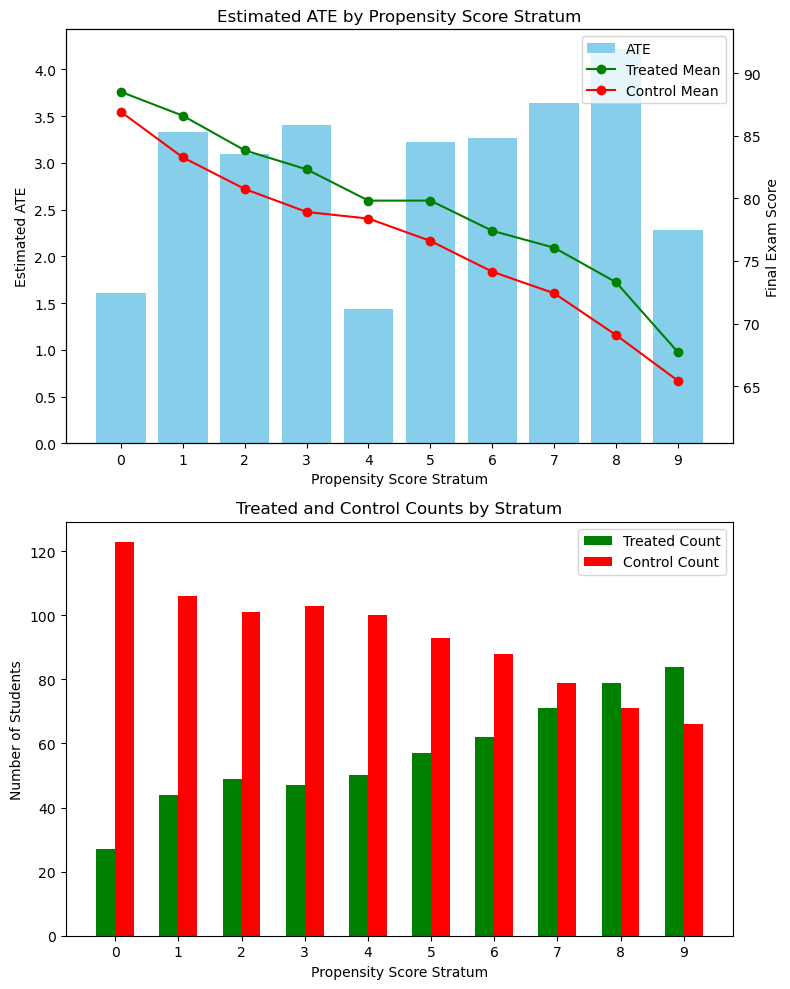

In [127]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,10))

# Plot ATE bars
ax1.bar(strata_df["Stratum"], strata_df["ATE"], color="skyblue", label="ATE")
ax1.set_xlabel("Propensity Score Stratum")
ax1.set_ylabel("Estimated ATE")
ax1.set_xticks(strata_df["Stratum"])

# Secondary axis for Treated/Control means
ax1b = ax1.twinx()
ax1b.plot(strata_df["Stratum"], strata_df["Treated_Mean"], marker='o', color='green', label='Treated Mean')
ax1b.plot(strata_df["Stratum"], strata_df["Control_Mean"], marker='o', color='red', label='Control Mean')
ax1b.set_ylabel("Final Exam Score")
ax1b.set_ylim(min(strata_df["Control_Mean"])-5, max(strata_df["Treated_Mean"])+5)

# Combine legends
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax1b.get_legend_handles_labels()
ax1b.legend(lines_1 + lines_2, labels_1 + labels_2, loc="upper right")

ax1.set_title("Estimated ATE by Propensity Score Stratum")

# plot: Treated & Control Counts
ax2.bar(strata_df["Stratum"]-0.15, strata_df["Treated_Count"], width=0.3, color='green', label='Treated Count')
ax2.bar(strata_df["Stratum"]+0.15, strata_df["Control_Count"], width=0.3, color='red', label='Control Count')
ax2.set_xlabel("Propensity Score Stratum")
ax2.set_ylabel("Number of Students")
ax2.set_xticks(strata_df["Stratum"])
ax2.legend()
ax2.set_title("Treated and Control Counts by Stratum")

plt.tight_layout()
plt.show()